In [1]:
from irbasis_util.four_point_ph_view import *
from irbasis_util.internal import *
from irbasis_util.regression import *
from irbasis_util.tensor_regression import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#padding on the y axis between label and axis
plt.rcParams['ytick.major.pad']='10'

dpi_out = 400
fig_width = 3.39
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches
MAX_HEIGHT_INCHES = 8.0
if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES
#fig, ax = plt.subplots(figsize = (fig_width, fig_height), frameon=True)
small_tick_size = 8
small_label_size = 8

In [3]:
# Implementation of Rohringer et al. () 2012)
def _delta(i, j):
    if i==j:
        return 1
    else:
        return 0

def _F_ph(U, beta, n, np, m):
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    r1 = nu + omega
    r2 = nu_p + omega
    tmp = 1. / (nu * r1 * r2 * nu_p)
    Fuu = (-0.25 * beta * (U**2) * (_delta(n,np) - _delta(m,0)) *
               (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    t1 = 0.125 * (U**3) * (nu**2 + r1**2 + r2**2 + nu_p**2) * tmp
    t2 = (3.0 / 16.0) * (U**5) * tmp
    t3 = (beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(0.5 * beta * U)))
              * (2 * _delta(nu, -nu_p - m) + _delta(m, 0)) *
              (1 + 0.25 * (U / r1)**2) * (1 + 0.25 * (U / r2)**2))
    t4 = (-beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(-0.5 * beta * U)))
              * (2 * _delta(nu, nu_p) + _delta(m, 0)) *
              (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    Fud = -U + t1 + t2 + t3 + t4
    return Fuu, Fud

def _G2_conn_ph(U, beta, n, np, m):
    Fuu, Fud = _F_ph(U, beta, n, np, m)
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    hU = 0.5 * U
    leggs_1 = nu * (nu + omega) * nu_p * (nu_p + omega)
    leggs_2 = ((hU**2 + nu**2) * (hU**2 + nu_p**2) *
                   (hU**2 + (nu + omega)**2) * (hU**2 + (nu_p + omega)**2))
    leggs = leggs_1 / leggs_2
    return (leggs * Fuu + leggs * Fud)

In [13]:
def elbow_method(alphas, squared_errors):
    """
    
    Parameters
    ----------
    alphas    regularization parameters in ascending order
    squared_errors  corresponding squared_errors

    Returns index of optimal value of alpha in alphas
    -------

    """
    x = numpy.log(alphas)
    y = numpy.log(squared_errors)
    
    a = (y[-1] - y[0])/(x[-1] - x[0])
    y -= a * (x - x[0]) + y[0]
    
    r = numpy.argmin(y)
    if isinstance(r, numpy.int64):
        return r
    else:
        return r[0]

# Regression with multiple values of alpha
def kruskal_complex_alphas(tensors_A, y, alphas, rank, decomposed_S):
    """
    
    Parameters
    ----------
    A
    y
    alphas  regularization parameters in ascending order

    Returns
    -------
    
     Nw, Nr, freq_dim, linear_dim, tensors_A, y, alpha, D):

    """
    coeffs_alpha = []
    squared_errors_alpha = []
    Nw, Nr, linear_dim = tensors_A[0].shape
    print(Nw, Nr, linear_dim)
    for i, alpha in enumerate(alphas):
        #print(tensors_A)
        #print(y)
        print("alpha ", alpha)
        precond = None
        model = OvercompleteGFModel(Nw, Nr, 2, linear_dim, tensors_A, y, alpha, rank)
        info = optimize_als(model, 1000, tol_rmse = 1e-4, solver='lsqr', verbose = 1)
        coeffs = model.full_tensor_x()
        coeffs_alpha.append(coeffs)
        e = model.mse()
        print("alpha = ", alpha, e, " num_ite", len(info['losss']))
        squared_errors_alpha.append(e)
    
    squared_errors_alpha = numpy.array(squared_errors_alpha)
        
    # Choose optimal alpha using Elbow method 
    opt_idx = elbow_method(alphas, squared_errors_alpha)
    
    return coeffs_alpha, squared_errors_alpha, opt_idx

In [11]:
boson_freq = 10
Lambda = 100.0
beta = 5.0
U = 2.0
wmax = Lambda / beta
rank = 10

numpy.random.seed(100)
#noise = 0.0012
# 2% error
noise = 1e-4

In [6]:
#alpha = 1e-15
augmented = True
phb = FourPointPHView(boson_freq, Lambda, beta, 1e-5, augmented)
Nl = phb.Nl
whichl = Nl - 1
print("Nl", Nl)
# build the sampling frequency structure
sp = phb.sampling_points_matsubara(whichl)
#print(S.shape)
n_sp = len(sp)

Nl 19


In [7]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
# S: [(3, 2, 2, Nl), (3, 2, 2, Nl)]
# prj = S * prj
def construct_prj(sp):
    n_sp = len(sp)
    prj = phb.projector_to_matsubara_vec(sp, decomposed_form=True)
    S = phb.normalized_S(decomposed_form=True)
    for i in range(2):
        prj[i] *= S[i][None, :, :, :, :]
        prj[i] = prj[i].reshape((n_sp, 12, Nl))
    return prj
prj = construct_prj(sp)
S_decomposed = phb.normalized_S(decomposed_form=True)

# Build the check frequency structure
n1n2_check = []
niw = 100
niw_hf = 10000
wide_niw_check = numpy.hstack((range(-niw_hf, -niw, 500), range(-niw, niw, 10), range(niw, niw_hf, 500)))
for i, j in product(wide_niw_check, repeat=2):
    n1n2_check.append((i, j))
prj_check = construct_prj(n1n2_check)

numpy.random.seed(200)
Giwn = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in sp])
print ("adding noise")
noise_iwn = numpy.random.normal(loc=0.0, scale=noise, size=(len(sp)))
Giwn = noise_iwn + Giwn
#print(Giwn.imag)

adding noise


In [15]:
#numpy.seterr(all='raise')
alphas = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
#alphas = [10]
%time coeffs_alpha, se_alpha, opt_alpha_idx = kruskal_complex_alphas(prj, Giwn, alphas, rank, S_decomposed)

2736 12 19
alpha  1
Number of iterations in LSQR =  152
time, 0.022279739379882812 0.2274491786956787
Number of iterations in LSQR =  6
Number of iterations in LSQR =  3
epoch =  0  loss =  8.478692599893367e-06  rmse =  0.0028274801315430614  coeff =  1.0
norm of x  0 0.03174129079033677
norm of x  1 0.0177995004967069
norm of x  2 0.00015972129916615605
Number of iterations in LSQR =  2
time, 0.024169921875 0.0138702392578125
Number of iterations in LSQR =  1
alpha =  1 7.99466254259983e-06  num_ite 1
alpha  0.1
Number of iterations in LSQR =  356
time, 0.02492499351501465 0.5772368907928467
Number of iterations in LSQR =  10
Number of iterations in LSQR =  5
epoch =  0  loss =  9.178243780294873e-06  rmse =  0.002818982431558951  coeff =  1.0
norm of x  0 0.04840854857379885
norm of x  1 0.1752065657462263
norm of x  2 0.025599818196123326
Number of iterations in LSQR =  4
time, 0.026993989944458008 0.019333839416503906
Number of iterations in LSQR =  3
Number of iterations in LSQR 

Number of iterations in LSQR =  267
time, 0.023102283477783203 0.3863039016723633
Number of iterations in LSQR =  43
Number of iterations in LSQR =  36
Number of iterations in LSQR =  130
time, 0.02609705924987793 0.1904439926147461
Number of iterations in LSQR =  38
Number of iterations in LSQR =  34
Number of iterations in LSQR =  107
time, 0.025818824768066406 0.16008305549621582
Number of iterations in LSQR =  34
Number of iterations in LSQR =  36
Number of iterations in LSQR =  100
time, 0.027801990509033203 0.16391587257385254
Number of iterations in LSQR =  36
Number of iterations in LSQR =  38
Number of iterations in LSQR =  95
time, 0.02677774429321289 0.13781023025512695
Number of iterations in LSQR =  35
Number of iterations in LSQR =  36
Number of iterations in LSQR =  93
time, 0.022119998931884766 0.13261103630065918
Number of iterations in LSQR =  35
Number of iterations in LSQR =  35
Number of iterations in LSQR =  87
time, 0.023427963256835938 0.1275019645690918
Number 

Number of iterations in LSQR =  302
time, 0.026765108108520508 0.6295857429504395
Number of iterations in LSQR =  88
Number of iterations in LSQR =  92
Number of iterations in LSQR =  288
time, 0.024183988571166992 0.5373239517211914
Number of iterations in LSQR =  86
Number of iterations in LSQR =  93
Number of iterations in LSQR =  279
time, 0.025165081024169922 0.5135250091552734
Number of iterations in LSQR =  85
Number of iterations in LSQR =  92
Number of iterations in LSQR =  273
time, 0.024637937545776367 0.4232521057128906
Number of iterations in LSQR =  87
Number of iterations in LSQR =  93
Number of iterations in LSQR =  264
time, 0.023730993270874023 0.45562195777893066
Number of iterations in LSQR =  83
Number of iterations in LSQR =  91
Number of iterations in LSQR =  252
time, 0.024317026138305664 0.3961329460144043
Number of iterations in LSQR =  82
Number of iterations in LSQR =  88
Number of iterations in LSQR =  248
time, 0.038823843002319336 0.48154497146606445
Numb

Number of iterations in LSQR =  230
Number of iterations in LSQR =  480
time, 0.035871028900146484 1.0720009803771973
Number of iterations in LSQR =  181
Number of iterations in LSQR =  230
Number of iterations in LSQR =  480
time, 0.03835582733154297 1.085042953491211
Number of iterations in LSQR =  185
Number of iterations in LSQR =  223
epoch =  20  loss =  2.144547653632495e-08  rmse =  9.879716411169846e-05  coeff =  1.0
norm of x  0 0.2925881512771472
norm of x  1 1.359935464100325
norm of x  2 1.1233313932240656
Number of iterations in LSQR =  480
time, 0.029514789581298828 0.8967561721801758
Number of iterations in LSQR =  181
Number of iterations in LSQR =  236
Number of iterations in LSQR =  480
time, 0.03408408164978027 1.1442549228668213
Number of iterations in LSQR =  177
Number of iterations in LSQR =  232
Number of iterations in LSQR =  480
time, 0.03829598426818848 0.9705290794372559
Number of iterations in LSQR =  176
Number of iterations in LSQR =  233
Number of itera

Number of iterations in LSQR =  378
Number of iterations in LSQR =  445
Number of iterations in LSQR =  480
time, 0.027376890182495117 1.1231179237365723
Number of iterations in LSQR =  380
Number of iterations in LSQR =  443
Number of iterations in LSQR =  480
time, 0.03620004653930664 1.1300718784332275
Number of iterations in LSQR =  382
Number of iterations in LSQR =  439
Number of iterations in LSQR =  480
time, 0.03504681587219238 1.019139051437378
Number of iterations in LSQR =  383
Number of iterations in LSQR =  441
Number of iterations in LSQR =  480
time, 0.034269094467163086 1.0297856330871582
Number of iterations in LSQR =  383
Number of iterations in LSQR =  460
Number of iterations in LSQR =  480
time, 0.035035133361816406 0.761911153793335
Number of iterations in LSQR =  393
Number of iterations in LSQR =  457
Number of iterations in LSQR =  480
time, 0.02852177619934082 0.7635679244995117
Number of iterations in LSQR =  393
Number of iterations in LSQR =  456
Number of

Number of iterations in LSQR =  480
time, 0.027328014373779297 0.6720812320709229
Number of iterations in LSQR =  760
Number of iterations in LSQR =  760
Number of iterations in LSQR =  480
time, 0.026996374130249023 0.8430516719818115
Number of iterations in LSQR =  760
Number of iterations in LSQR =  760
Number of iterations in LSQR =  480
time, 0.026766061782836914 0.71207594871521
Number of iterations in LSQR =  760
Number of iterations in LSQR =  760
Number of iterations in LSQR =  480
time, 0.02650594711303711 0.7767519950866699
Number of iterations in LSQR =  760
Number of iterations in LSQR =  760
Number of iterations in LSQR =  480
time, 0.028219223022460938 0.7813777923583984
Number of iterations in LSQR =  760
Number of iterations in LSQR =  760
Number of iterations in LSQR =  480
time, 0.027261018753051758 0.8936197757720947
Number of iterations in LSQR =  760
Number of iterations in LSQR =  760
epoch =  40  loss =  1.0206796424353861e-08  rmse =  9.542660177038503e-05  coe

In [16]:
print(se_alpha)

[7.99466254e-06 7.99466254e-06 1.53217768e-07 3.36965821e-08
 1.15962084e-08 9.41717675e-09 9.22319666e-09 9.10623633e-09]


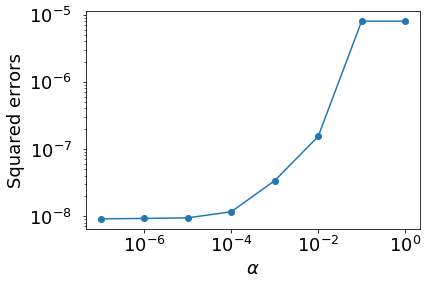

In [17]:
plt.plot(alphas, se_alpha, marker='o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Squared errors')
plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')

In [18]:
# OK, let us alpha = 0.1.
# An optimal value can be estimated by the elbow method (refer to the SpM paper by J. Otsuki et al.)
#alpha_best = 0.1
#opt_alpha_idx = 0
alpha_best = alphas[opt_alpha_idx]
print("best value of alpha", alpha_best)
#alpha_best = 0.1

coeffs = coeffs_alpha[opt_alpha_idx].reshape((3, 2, 2, Nl, Nl))
#print(coeffs.shape)

best value of alpha 0.0001


In [19]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
def compute_Giwn(prj, coeff):
    niw = prj[0].shape[0]
    #print(prj[0].shape)
    prj_mat = numpy.einsum('nrl,nrm->nrlm', prj[0], prj[1]).reshape((niw, 3 * 2 * 2 * Nl * Nl))
    return prj_mat@coeffs.reshape((3 * 2 * 2 * Nl * Nl))

Giwn_check = compute_Giwn(prj_check, coeffs)
print(Giwn_check.shape)
Giwn_check_ref = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in n1n2_check])

diff = numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref))
print(diff)
print(diff < 1e-3)

(3600,)
0.0003461441316933442
True


[-1.45096721e-04  1.90999329e-04  7.09682155e-05 ...  1.45807794e-04
  7.79075394e-04  2.13534554e-05]


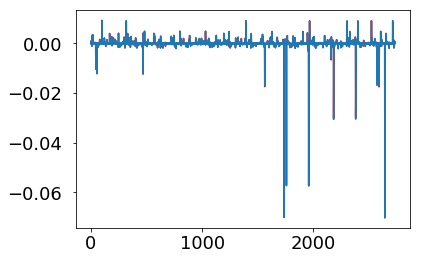

In [20]:
Giwn_reconst = compute_Giwn(prj, coeffs)
plt.plot(Giwn_reconst.real, c='r')
plt.plot(Giwn.real)
print(Giwn.real)

0.07012537833753249


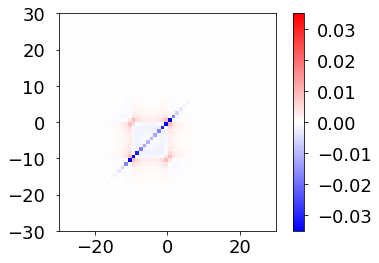

In [21]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

N = 100
N_zoom = 30
#x = numpy.linspace(-N, N, 2*N+1)
x = numpy.arange(-N, N+1)
G2_conn_ph = numpy.zeros((2 * N + 1,2 * N + 1), dtype=float)

for i in range(2 * N + 1):
    for j in range(2 * N + 1):
        n = x[i]
        np = x[j]
        G2_conn_ph[i, j] = _G2_conn_ph(U, beta, n, np, boson_freq)

vrange = numpy.amax(numpy.abs(G2_conn_ph))
plt.imshow(G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()
print (vrange)

#plt.legend(loc='best',shadow=True,frameon=False)

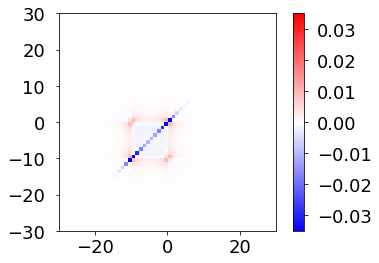

In [22]:
n1n2_check_2d = numpy.array([(x[i], x[j]) for i in range(2 * N + 1) for j in range(2 * N + 1)])
prj_check_2d = construct_prj(n1n2_check_2d)

Giwn_check = compute_Giwn(prj_check_2d, coeffs)
Giwn_check = Giwn_check.reshape((2 * N + 1, 2 * N + 1))
vrange = numpy.amax(numpy.abs(Giwn_check))
plt.imshow(Giwn_check.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()

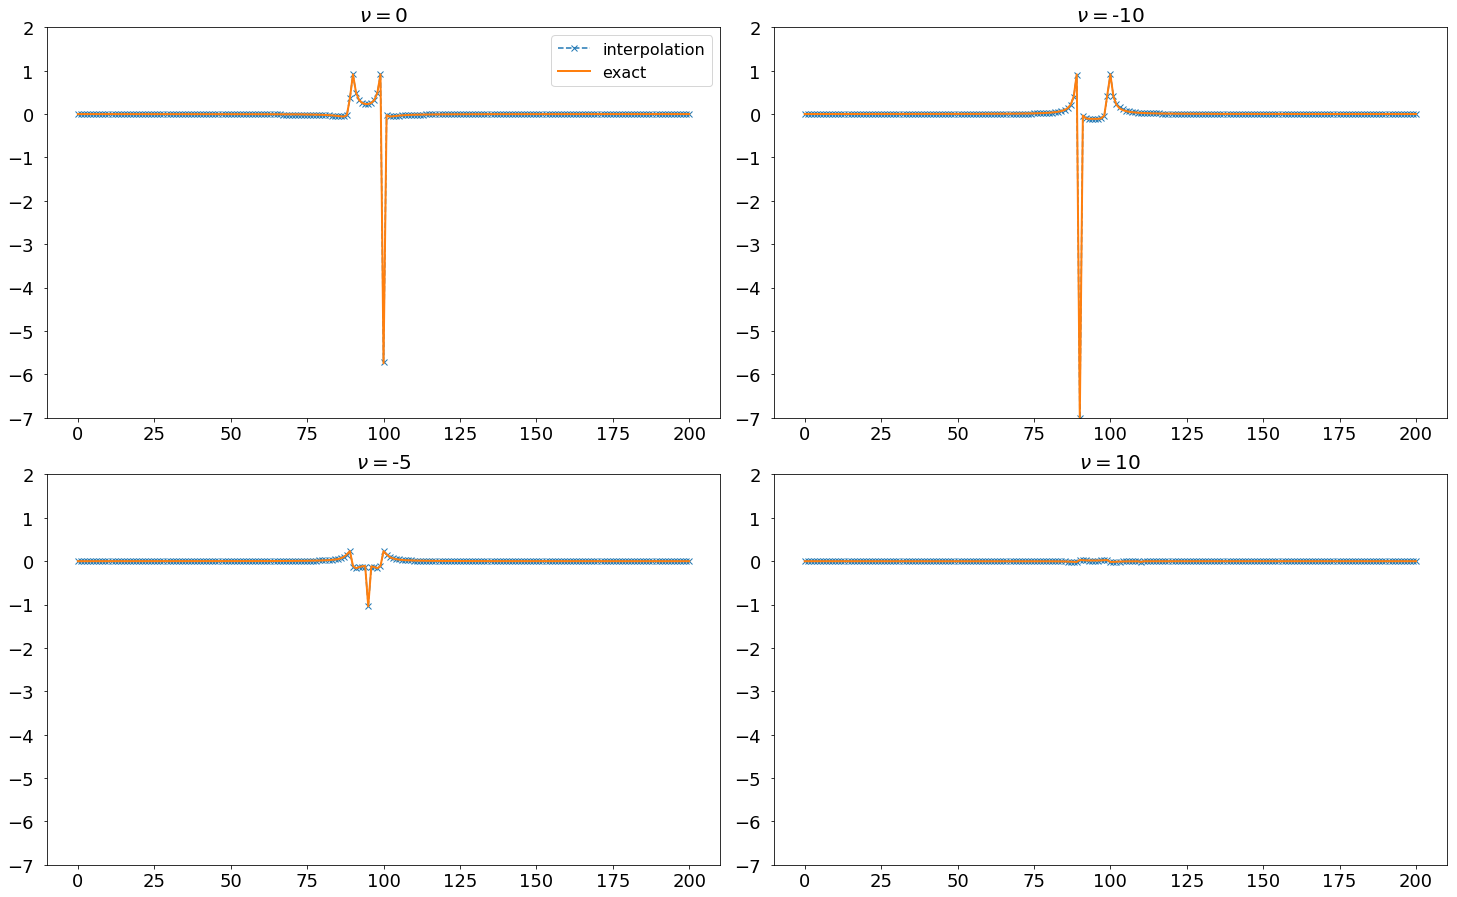

In [23]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_wide.pdf")

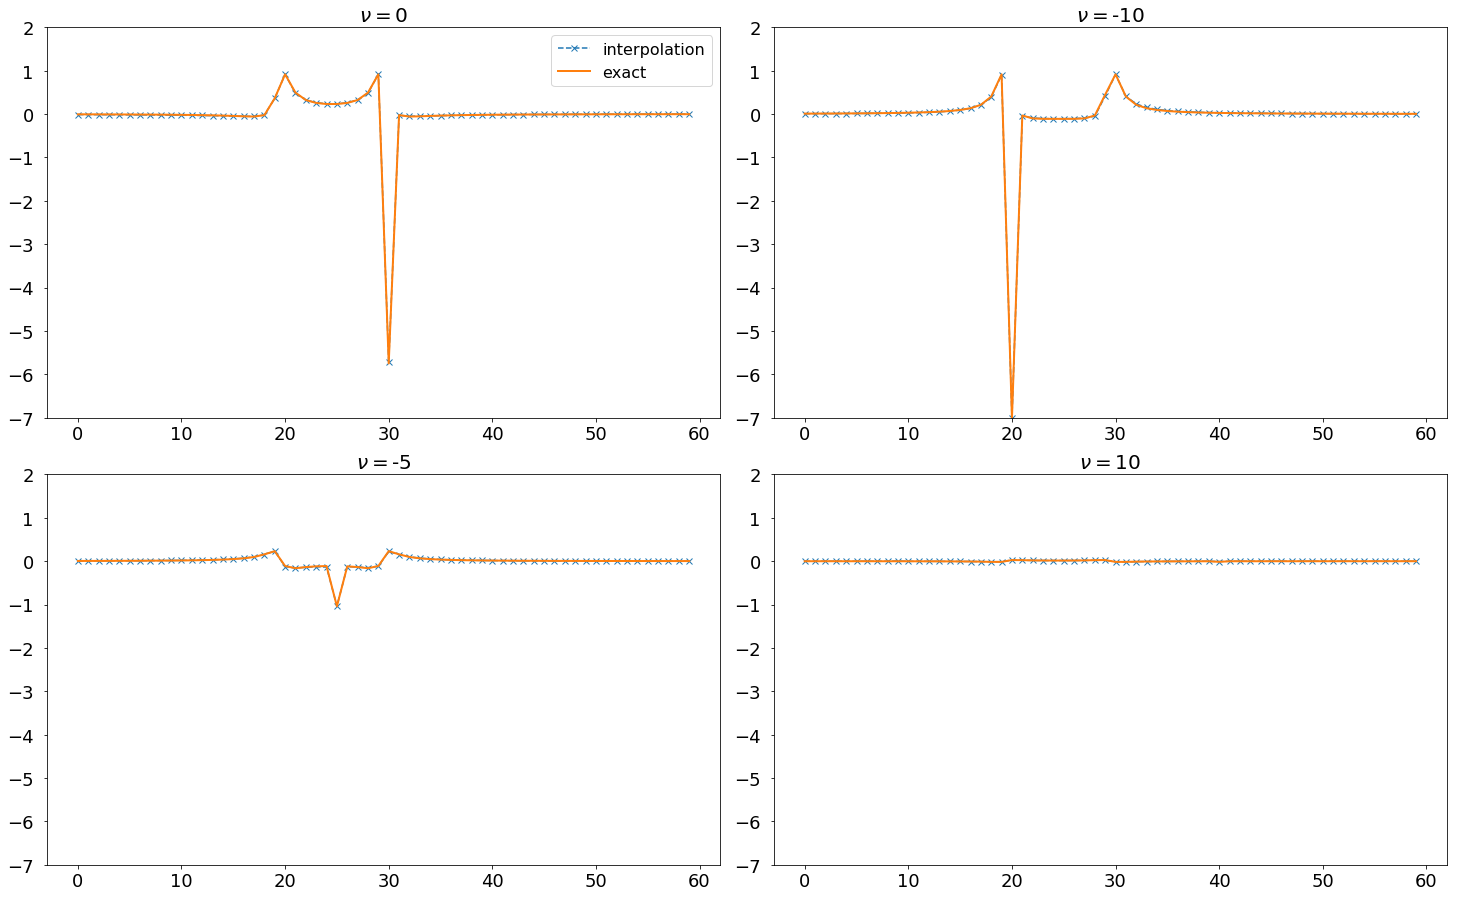

In [24]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_zoom.pdf")